# Neyman construction for a Gaussian (at a physical boundary)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import integrate
from scipy import optimize
from scipy import interpolate
from scipy.stats import norm
from scipy.stats import chi2
%config InlineBackend.figure_format = 'retina'

In [2]:
# Gaussian with/without boundary
boundary = True

In [3]:
# Set fonts
plt.rc('font',**{'family':'Helvetica','size':16})
plt.rc('text', usetex=True)
font = {'family':'Helvetica',
        'color' : 'black',
        'size'  :  16}

Let's assume a Gaussian:
$$p(\hat\mu, \mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{e}^{-\frac{(\hat\mu-\mu)^2}{2\sigma^2}}$$
and the free parameters:
- $\mu$: theory parameter, which is the mean of the Gaussian 
- $\hat\mu$: measured value of the parameter
- $\sigma$: standard deviation of Gaussian; here $\sigma=1$

Moreover, the parameter $\mu$ cannot be negative, i.e. there is a physical border at $\mu=0$.

In [4]:
# theory means
mus = np.arange(0.001, 4.5, 0.06) #0.05
# MLEs
muhats = np.arange(-5.5,4, 0.01)
# actually observed value
muobs = np.arange(0,2, 0.05)
muob = 0.25
# set standard deviation to 1
sigma = 1.
# Choose confidence level
alphas = np.array([0.3173,0.0455]) 
print(1-alphas)

[0.6827 0.9545]


Define the likelihood ratio test statistic:
$$ t^\mathrm{LR}_\mu = -2 \log\frac{\mathcal{L}(x|\mu)}{\mathcal{L}(x|\hat{\mu}_\mathrm{phys})}
= \begin{cases}
        \frac{\mu^2-2 \mu\hat\mu}{\sigma^2} \quad &\text{for}\ x< 0,\\
        \frac{(\hat\mu-\mu)^2}{\sigma^2}\quad &\text{for}\ x\ge 0,
    \end{cases}$$
where $\hat\mu_\mathrm{phys}$ is the physically allowed MLE of $\mu$. This means if $\hat\mu<0$, then $\hat\mu_\mathrm{phys}=0$; if $\hat\mu\ge 0$, then $\hat\mu_\mathrm{phys} = \hat\mu$; and $x$ is some data set used to measure $\mu$. 

In [5]:
# probability
def P(muhat, mu, sigma):
    return np.exp(-(muhat-mu)**2/(2.*sigma**2))/np.sqrt(2.*np.pi*sigma**2)

# LR test statistic
if boundary:
    def t_LR(muhat, mu, sigma):
        modified = (mu**2 - 2*muhat*mu)/sigma**2
        original = (muhat-mu)**2/sigma**2
        return np.where(muhat<0, modified, original)
else:
    def t_LR(muhat, mu, sigma):
        return (muhat-mu)**2/sigma**2
    
# integral of p.d.f.    
def integral(muhat1, muhat2, muhat, mu, sigma):
    return integrate.quad(P(muhat, mu, sigma), muhat1, muhat2)

The LR test statistic becomes more asymmetric the closer $\hat\mu$ is to $0$:

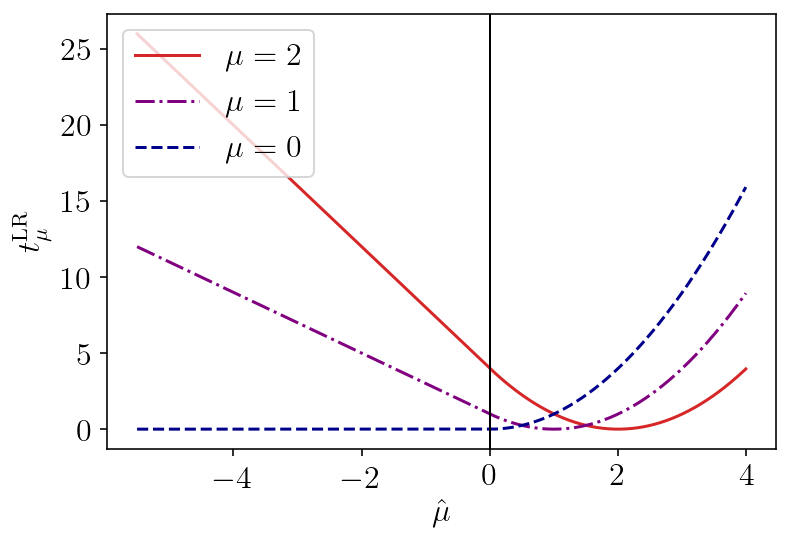

In [6]:
plt.plot(muhats, t_LR(muhats, mu=2, sigma=sigma), color='tab:red', label=r"$\mu=2$", ls="-")
plt.plot(muhats, t_LR(muhats, mu=1, sigma=sigma), color='purple', label=r"$\mu=1$", ls="-.")
plt.plot(muhats, t_LR(muhats, mu=0., sigma=sigma), color='darkblue', label=r"$\mu=0$", ls="--")
plt.xlabel(r"$\hat\mu$")
plt.ylabel(r"$t^\mathrm{LR}_\mu$")
plt.axvline(0, color="black", lw=1)
plt.legend(loc="upper left")
plt.show()

In [7]:
# Define variables
N_alpha = len(alphas)
N_mu = len(mus)

muhats1 = np.ones((N_alpha,N_mu))
muhats2 = np.ones((N_alpha,N_mu))

The Neyman belt can be constructed as follows:

For a fixed confidence level, e.g. $(1-\alpha) = 0.6827$ corresponding to $1\sigma$ (or $(1-\alpha) = 0.9545$ corresponding to $2\sigma$), one picks a hypothetical true value $\mu^{(i)}$. For this $\mu^{(i)}$, we determine $x^{(i)}_1$ and $x^{(i)}_2$, such that:
$$\int_{x^{(i)}_1}^{x^{(i)}_2} P(x,\,\mu^{(i)})\,\mathrm{d}x = (1-\alpha),$$
and such that the LR is the same in $x^{(i)}_1$ and $x^{(i)}_2$:
$$t_\mathrm{LR}(x^{(i)}_1) = t_\mathrm{LR}(x^{(i)}_2).$$

In [8]:
for a in np.arange(0, N_alpha):
    for n in np.arange(0, N_mu):
    
        alpha = alphas[a]
        mu = mus[n]
    
        def P_muhat(muhat):
            return P(muhat, mu, sigma)

        def equations(p):
            muhat1, muhat2 = p
            return (integrate.quad(P_muhat, muhat1, muhat2)[0] - (1-alpha), t_LR(muhat1, mu, sigma)-t_LR(muhat2, mu, sigma))
        # method = 'lm', 'hybr', 'anderson', 'df-sane'
        muhats1[a][n], muhats2[a][n] = optimize.root(equations, (muhats1[a][n],muhats2[a][n]), method='lm').x

In [9]:
# Interpolate x1(mu) and x2(mu)
muhat1_mu = [interpolate.make_interp_spline(mus, muhats1[a]) for a in np.arange(0, N_alpha)]
muhat2_mu = [interpolate.make_interp_spline(mus, muhats2[a]) for a in np.arange(0, N_alpha)]

This gives a confidence interval in $x$ for each hypothetical true value of $\mu$. Together these confidence intervals give the Neyman belt:

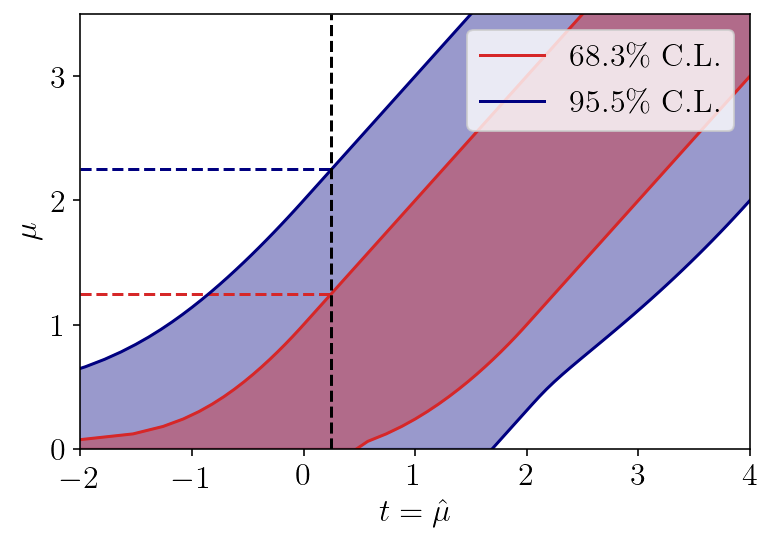

In [10]:
plt.plot(muhat1_mu[0](mus), mus, ls="-", color="tab:red")
plt.plot(muhat2_mu[0](mus), mus, ls="-", color="tab:red", label="68.3\% C.L.")
plt.plot(muhat1_mu[1](mus), mus, ls="-", color="navy")
plt.plot(muhat2_mu[1](mus), mus, ls="-", color="navy", label="95.5\% C.L.")
plt.fill_betweenx(mus, muhat1_mu[1](mus), muhat2_mu[1](mus), color="navy", alpha="0.4")
plt.fill_betweenx(mus, muhat1_mu[0](mus), muhat2_mu[0](mus), color="tab:red", alpha="0.4")
plt.ylabel(r"$\mu$")
plt.xlabel(r"$t = \hat{\mu}$")
plt.axvline(muob, color="black", ls="--")
plt.hlines(1.25, -2, muob, color="tab:red", ls="--")
plt.hlines(2.25, -2, muob, color="navy", ls="--")
plt.xlim(-2,4)
plt.ylim(0,3.5)
plt.legend(loc = "upper right")
plt.savefig("Neyman_belt.pdf", format="PDF", bbox_inches='tight')

Now assume we measure some value $\hat\mu_0$ in the experiment, then the confidence interval in the model parameter $\mu$ is given by the intersection of $\hat\mu=\hat\mu_0$ with the confidence belt. The table below shows the 68\% and 95\% confidence intervals for different oberved values of $x_0$. This reproduces the table in the appendix of the Feldman-Cousins paper (https://arxiv.org/abs/physics/9711021).

In [11]:
# Determine confidence interval after measuring x_0
N_obs = len(muobs)
mu1s = np.ones((N_alpha, N_obs))
mu2s = np.ones((N_alpha, N_obs))

for a in np.arange(0, N_alpha):
    for n in np.arange(0, N_obs):
        
        def muobs1_eq(mu):
            return muhat2_mu[a](mu) - muobs[n]
    
        def muobs2_eq(mu):
            return muhat1_mu[a](mu) - muobs[n]
    
        mu1s[a][n] = optimize.root(muobs1_eq, mu1s[a][n]).x
        mu2s[a][n] = optimize.root(muobs2_eq, mu2s[a][n]).x
        if mu1s[a][n] < 0:
            mu1s[a][n] =0

In [12]:
#print("x0:     68\% C.L.,     95\% C.L.")
print("mu_obs:     68% C.L.,     95% C.L.")
for n in np.arange(0, N_obs):
    #line = "%(x0).1f &[%(mu1_0).2f, %(mu2_0).2f] &[%(mu1_1).2f, %(mu2_1).2f] \\\\"%{"x0":x0_array[n], "mu1_0":mu1_array[0][n], "mu2_0":mu2_array[0][n], "mu1_1":mu1_array[1][n], "mu2_1":mu2_array[1][n]}
    line = "%(x0).1f       [%(mu1_0).2f, %(mu2_0).2f] [%(mu1_1).2f, %(mu2_1).2f]"%{"x0":muobs[n], "mu1_0":mu1s[0][n], "mu2_0":mu2s[0][n], "mu1_1":mu1s[1][n], "mu2_1":mu2s[1][n]}
    print(line)

mu_obs:     68% C.L.,     95% C.L.
0.0       [0.00, 1.00] [0.00, 2.00]
0.1       [0.00, 1.05] [0.00, 2.05]
0.1       [0.00, 1.10] [0.00, 2.10]
0.2       [0.00, 1.15] [0.00, 2.15]
0.2       [0.00, 1.20] [0.00, 2.20]
0.2       [0.00, 1.25] [0.00, 2.25]
0.3       [0.00, 1.30] [0.00, 2.30]
0.4       [0.00, 1.35] [0.00, 2.35]
0.4       [0.00, 1.40] [0.00, 2.40]
0.5       [0.00, 1.45] [0.00, 2.45]
0.5       [0.00, 1.50] [0.00, 2.50]
0.6       [0.00, 1.55] [0.00, 2.55]
0.6       [0.07, 1.60] [0.00, 2.60]
0.7       [0.00, 1.65] [0.00, 2.65]
0.7       [0.11, 1.70] [0.00, 2.70]
0.8       [0.12, 1.75] [0.00, 2.75]
0.8       [0.14, 1.80] [0.00, 2.80]
0.9       [0.00, 1.85] [0.00, 2.85]
0.9       [0.00, 1.90] [0.00, 2.90]
1.0       [0.22, 1.95] [0.00, 2.95]
1.0       [0.24, 2.00] [0.00, 3.00]
1.1       [0.27, 2.05] [0.00, 3.05]
1.1       [0.30, 2.10] [0.00, 3.10]
1.2       [0.32, 2.15] [0.00, 3.15]
1.2       [0.35, 2.20] [0.00, 3.20]
1.2       [0.39, 2.25] [0.00, 3.25]
1.3       [0.42, 2.30] [0.00,

Instead of using $t = \hat\mu$ as a test statistic and $t_\mathrm{LR}$ as an ordering rule, one can directly use $t_\mathrm{LR}$ as a test statistic.

Using the band optained before:

In [13]:
t_LRs= np.zeros((2,N_mu))
for a in [0,1]:
    for n in np.arange(0, N_mu):
        mu = mus[n]
        muhat = muhats1[a][n]
        t_LRs[a][n] = t_LR(muhat, mu, sigma=sigma)

Now assume some $\hat\mu_\mathrm{obs}$, which translates into some $t_\mathrm{LR, obs}$:

In [14]:
tLR_obs = t_LR(muob, mus, sigma=sigma)

This gives the Neyman belt in the space of $t_\mathrm{LR}$. The 68\% (95\%) confidence region is shown as the red (blue) shaded area. Note that the line of the measurement $\hat\mu = \hat\mu_0$ is not a vertical line anymore but represents a parabola rotated by 90 degree (=profile likelihood). As above, the 68\% (95\%) confidence interval is given by the intersection of the $\hat\mu = \hat\mu_0$ (black dashed) line with the red (blue) line. Hence, using the Neyman construction for the LR test statistic smoothly transitions between a upper limit and a central confidence interval.

For values of $\mu$ far away from the physical boundary at $\mu=0$, the confidence band becomes a constant vertical line at $-2\log(t_\mathrm{LR})=1$ for the  68\% confidence interval and at $-2\log(t_\mathrm{LR})=4$ for the 95\% confidence interval. Hence, far away from the boundary $\mu=0$, one recoveres the simple graphical profile likelihood construction. 

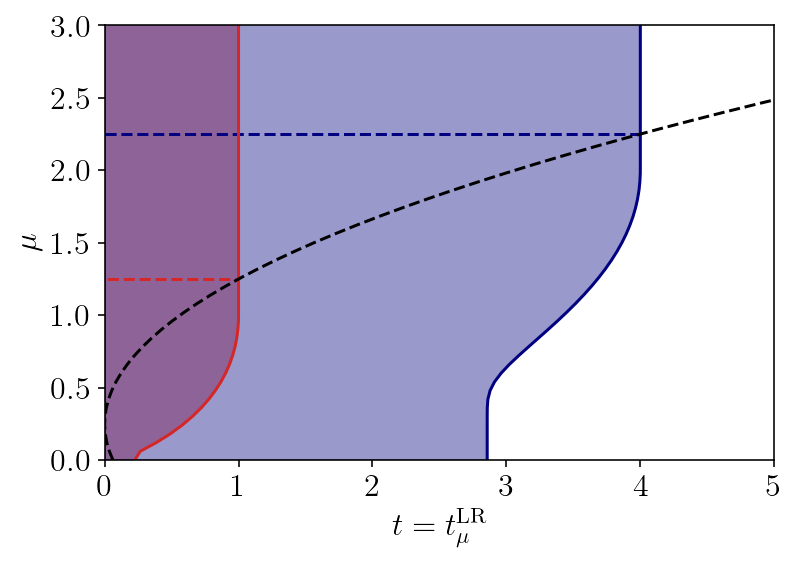

In [15]:
plt.plot(t_LRs[0], mus, ls="-", color="tab:red", label="68.3\% C.L.")
plt.fill_betweenx(mus, 0, t_LRs[0], color="tab:red", alpha="0.4")
plt.plot(t_LRs[1], mus, ls="-", color="navy", label="95.5\% C.L.")
plt.fill_betweenx(mus, 0, t_LRs[1],color="navy", alpha="0.4")
plt.plot(tLR_obs, mus, color="black", ls="--")
plt.hlines(1.25, -2, 1, color="tab:red", ls="--")
plt.hlines(2.25, 0, 4, color="navy", ls="--")
plt.ylabel(r"$\mu$")
plt.xlabel(r"$t = t^\mathrm{LR}_\mu$")

plt.xlim(-0,5)
plt.ylim(0,3)
plt.savefig("Neyman_construction_LRT.pdf", format="PDF", bbox_inches='tight')
plt.show()

Print this as a table:

In [16]:
#print(repr(mu_array))
#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
#print(repr(chi2[0]))

print("\mu     &68\% C.L.     &95\% C.L.")
#print("mu:    68% C.L.     95% C.L.")
for n in np.arange(0, N_obs):
    line = "    %(mu).2f    &%(chi2_0).3f     &%(chi2_1).3f \\\\ "%{"mu":mus[n], "chi2_0":t_LRs[0][n], "chi2_1":t_LRs[1][n]}
    #line = "%(mu).2f:    %(chi2_0).3f       %(chi2_1).3f"%{"mu":mu_array[n], "chi2_0":chi2[0][n], "chi2_1":chi2[1][n]}
    print(line)

\mu     &68\% C.L.     &95\% C.L.
    0.00    &0.226     &2.857 \\ 
    0.06    &0.265     &2.857 \\ 
    0.12    &0.384     &2.857 \\ 
    0.18    &0.488     &2.857 \\ 
    0.24    &0.577     &2.857 \\ 
    0.30    &0.654     &2.857 \\ 
    0.36    &0.721     &2.857 \\ 
    0.42    &0.778     &2.862 \\ 
    0.48    &0.827     &2.878 \\ 
    0.54    &0.868     &2.912 \\ 
    0.60    &0.903     &2.961 \\ 
    0.66    &0.932     &3.022 \\ 
    0.72    &0.955     &3.091 \\ 
    0.78    &0.973     &3.164 \\ 
    0.84    &0.986     &3.237 \\ 
    0.90    &0.995     &3.310 \\ 
    0.96    &0.999     &3.382 \\ 
    1.02    &1.000     &3.451 \\ 
    1.08    &1.000     &3.516 \\ 
    1.14    &1.000     &3.578 \\ 
    1.20    &1.000     &3.637 \\ 
    1.26    &1.000     &3.690 \\ 
    1.32    &1.000     &3.740 \\ 
    1.38    &1.000     &3.785 \\ 
    1.44    &1.000     &3.826 \\ 
    1.50    &1.000     &3.863 \\ 
    1.56    &1.000     &3.895 \\ 
    1.62    &1.000     &3.922 \\ 
    1.68    &1

Let's illustrate this by drawing mocks from a Gaussian:

In [17]:
# Settings
N_randoms = 1000000
nbins = 24

bin_width = 0.15
bin_max = 6
bins = np.arange(0, bin_max, bin_width)
bins_fine = np.arange(0, bin_max, bin_width/10)
nbins = len(bins)
norm_LR = bin_width*N_randoms

x_lim = 3
x_bin_width = 0.2
x_bins = np.arange(muob-x_lim, muob+x_lim, x_bin_width)
x_range = np.arange(muob-x_lim, muob+x_lim, x_bin_width/10.)
norm_x = x_bin_width*N_randoms

### Define acceptance regions
t_68 = 0.5897 
t_95 = 2.8566

In [18]:
# Draw from Gaussian
muhat_mocks = norm.rvs(size=N_randoms, loc=muob, scale=sigma)

/Users/lherold/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


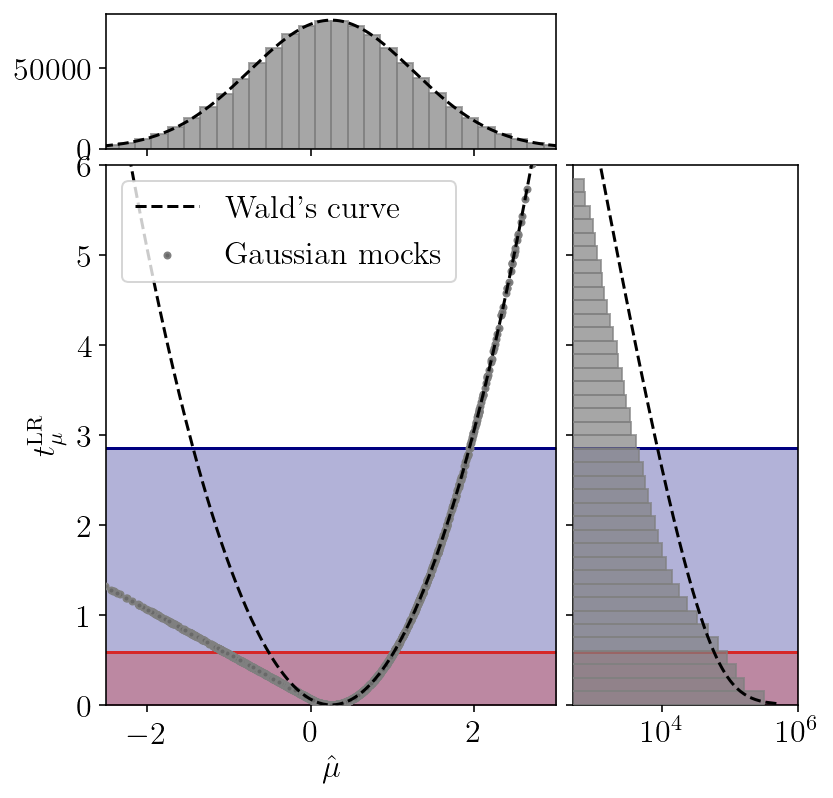

In [25]:
#### LR triangle plot
tLR_mocks = t_LR(muhat_mocks, muob, sigma)

# Initialise plot
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 2), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# Center plot
ax.fill_between([-4, 5], [0,0], [t_95,t_95], color="navy", alpha=0.3)
ax.fill_between([-4, 5], [0,0], [t_68,t_68], color="tab:red", alpha=0.3)
ax.axhline(t_68, color="tab:red", zorder=2)
ax.axhline(t_95, color="navy", zorder=2)
ax.scatter(muhat_mocks[0:1500], tLR_mocks[0:1500], color="dimgrey", marker=".", label=r"Gaussian mocks", edgecolor="grey", zorder=3)
ax.plot(x_range, (x_range-muob)**2/sigma**2, color='black', ls="--", lw=1.5, label="Wald's curve", zorder=4)


ax.set_ylim([0,6])
ax.set_xlim([-2.5,3.])
ax.set_xlabel(r"$\hat{\mu}$")
ax.set_ylabel(r"$t_\mu^\mathrm{LR}$")
ax.legend(loc="upper left")

# Hist x
ax_histx.plot(x_range, norm_x*norm.pdf(x_range, loc=muob, scale=sigma), color='black', ls="--", lw=1.5)
ax_histx.hist(muhat_mocks, bins=x_bins, color="grey", alpha=0.7, edgecolor="grey")

# Hist y
ax_histy.axhline(t_68, color="tab:red")
ax_histy.axhline(t_95, color="navy")
ax_histy.plot(norm_LR*chi2.pdf(bins_fine, df=1), bins_fine, color='black', ls="--", lw=1.5, zorder=4)
ax_histy.fill_between([0, 1e6], [0,0], [t_95, t_95], color="navy", alpha=0.3)
ax_histy.fill_between([0, 1e6], [0,0], [t_68, t_68], color="tab:red", alpha=0.3)
ax_histy.hist(tLR_mocks, bins=bins, orientation='horizontal', color="grey", alpha=0.7, edgecolor="grey", zorder=3)
ax_histy.set_xscale("log")
ax_histy.set_xlim(0,1e6)

plt.savefig("LR_hist_Gaussian_boundary.pdf", format="PDF", bbox_inches='tight')
plt.show()